In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
1,964 cases (7 day average) as of Tue 20 Apr, -3.9 since Mon 19 Apr
122 hospitalised (7 day average) as of Wed 21 Apr, +0.0 since Wed 21 Apr
14 died (7 day average) as of Tue 20 Apr, -0.6 since Mon 19 Apr


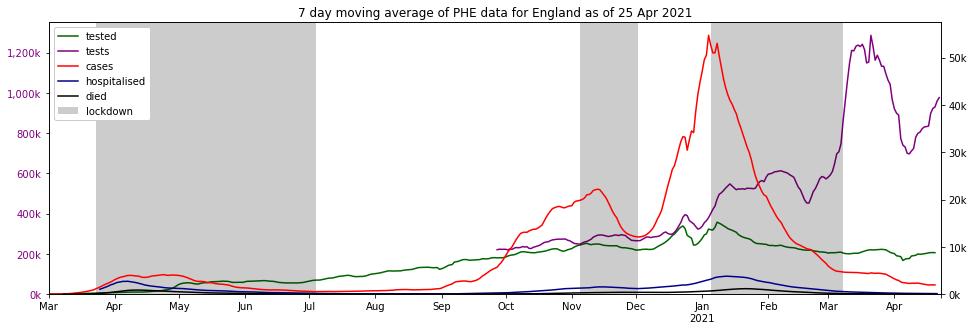

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

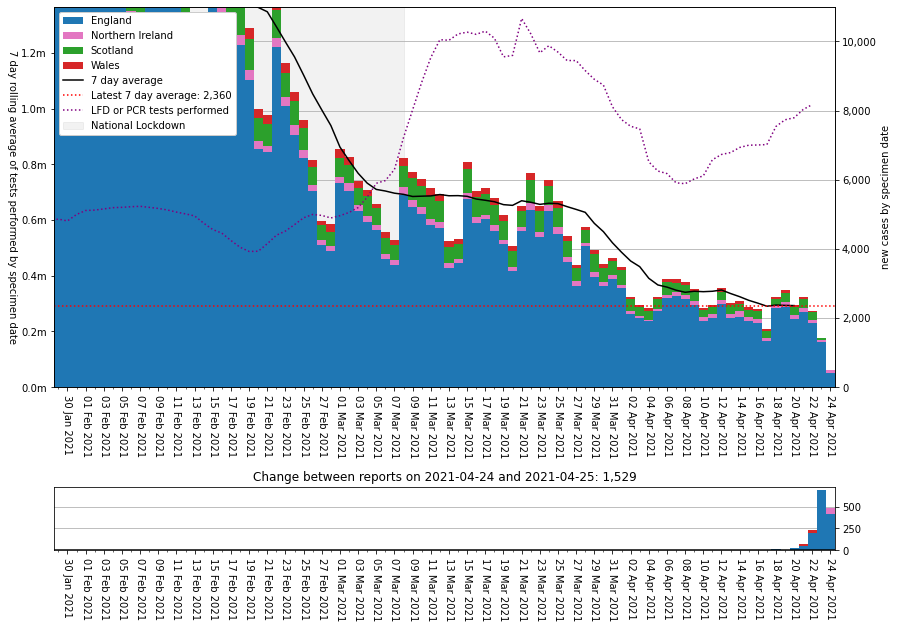

In [4]:
plot_areas(for_date, 'cases_nations', ylim=11_000, earliest='2021-01-29')

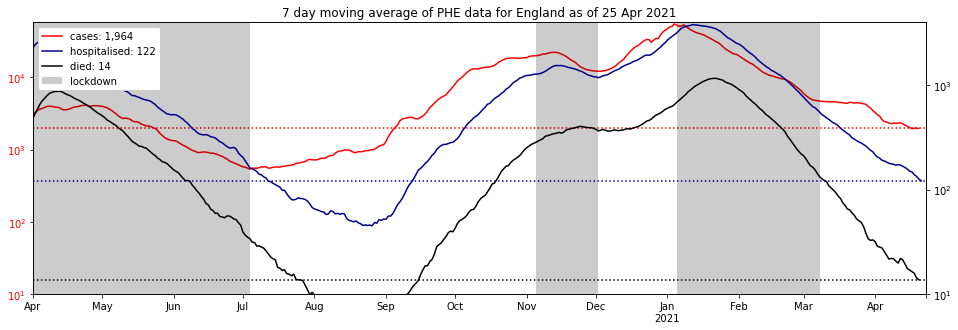

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

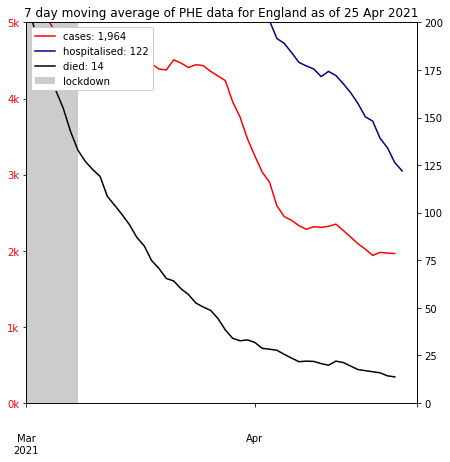

In [6]:
plot_summary(earliest_date='2021-03-01', show_latest=True, figsize=(7, 7),
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=5_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=200)

In [7]:
vaccination_changes()

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,10564692.0,28227710.0,17663018.0,56286961,18.769342,31.380301,49.850357
1,Northern Ireland,N92000002,342195.0,905736.0,563541.0,1893667,18.070495,29.759245,52.170260
2,Scotland,S92000003,993180.0,2764607.0,1771427.0,5463300,18.179123,32.424121,49.396757
3,Wales,W92000004,687049.0,1768585.0,1081536.0,3152879,21.791163,34.303124,43.905713


'partial: 33,666,638 (50.4%), full: 12,587,116'

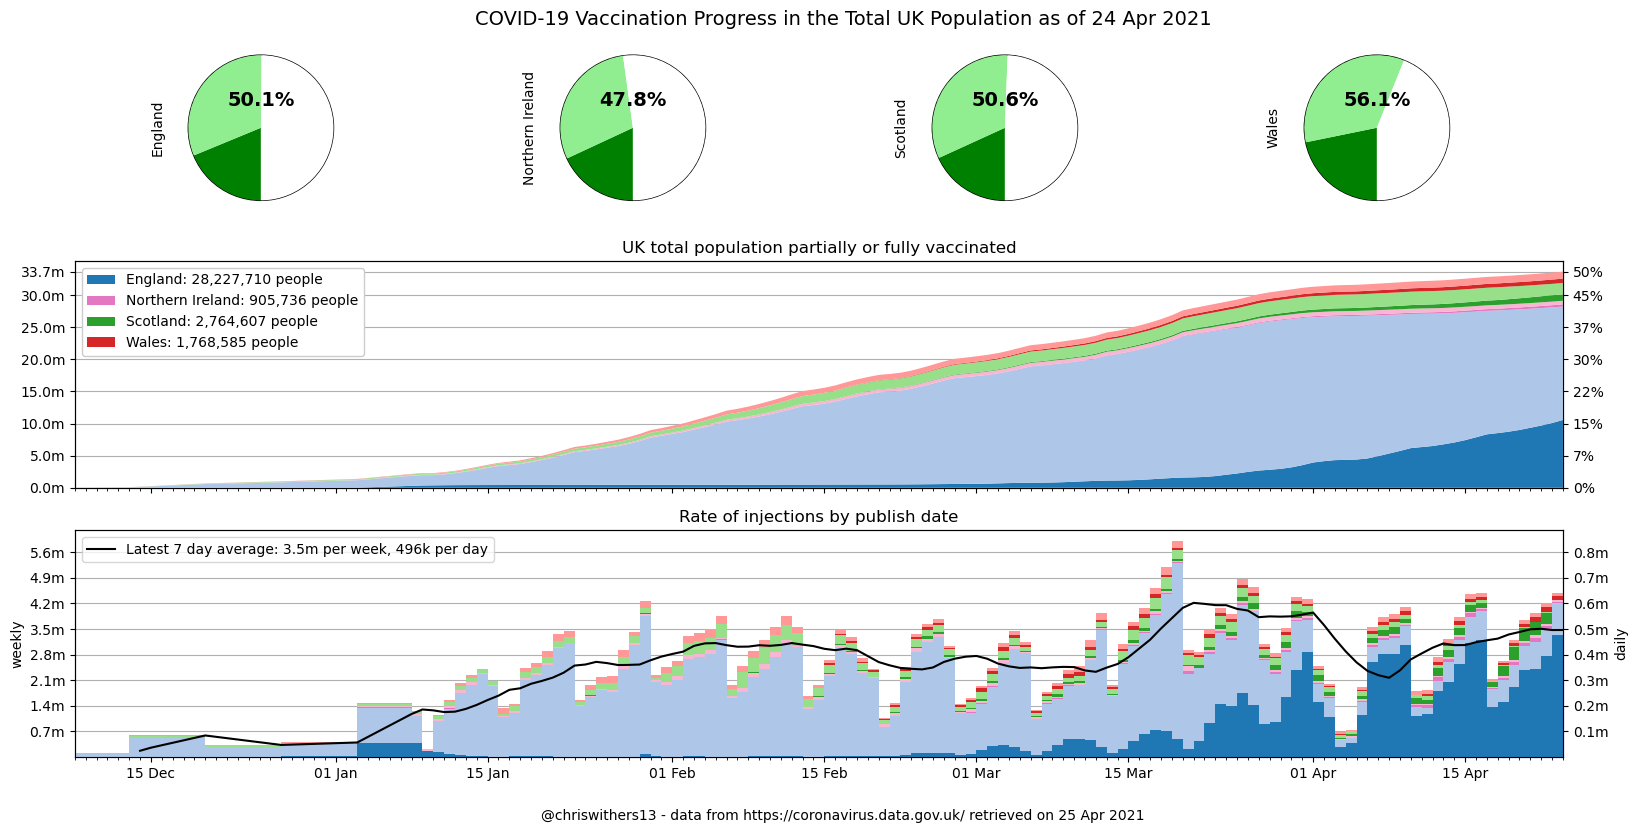

In [8]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

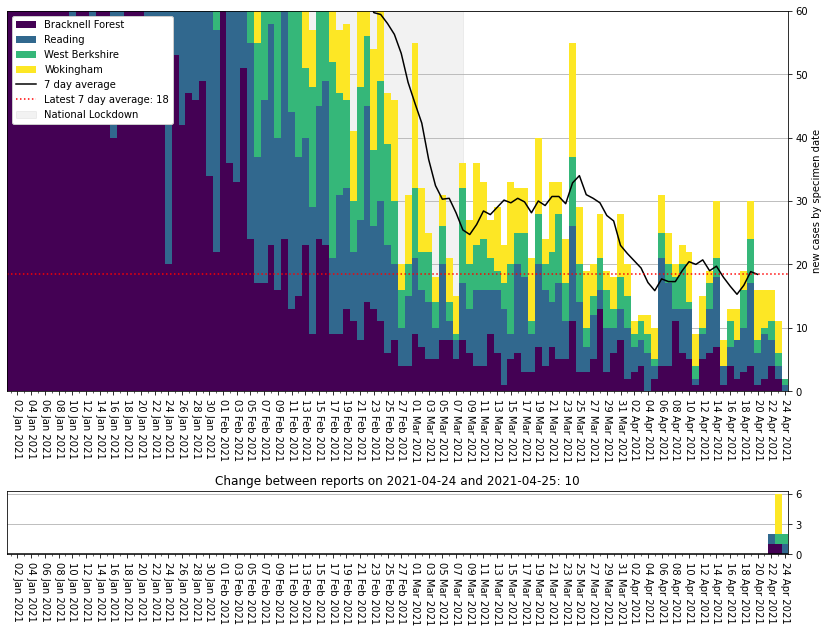

In [9]:
plot_areas(for_date, areas=my_areas, earliest='2021-01-01', ylim=60)

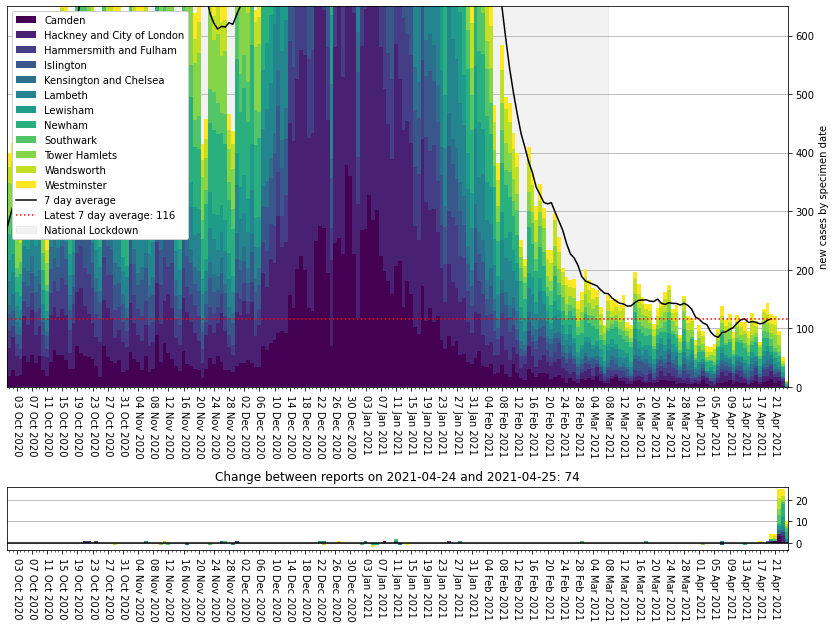

In [10]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000169,Selby,104.833370,95.0,2021-04-24
N09000005,Derry City and Strabane,84.609080,128.0,2021-04-24
N09000009,Mid Ulster,65.307551,97.0,2021-04-24
E08000034,Kirklees,65.258864,287.0,2021-04-24
E08000017,Doncaster,61.560165,192.0,2021-04-24
E06000013,North Lincolnshire,61.523460,106.0,2021-04-24
E07000008,Cambridge,54.488053,68.0,2021-04-24
E08000016,Barnsley,53.470304,132.0,2021-04-24
E08000036,Wakefield,52.826202,184.0,2021-04-24


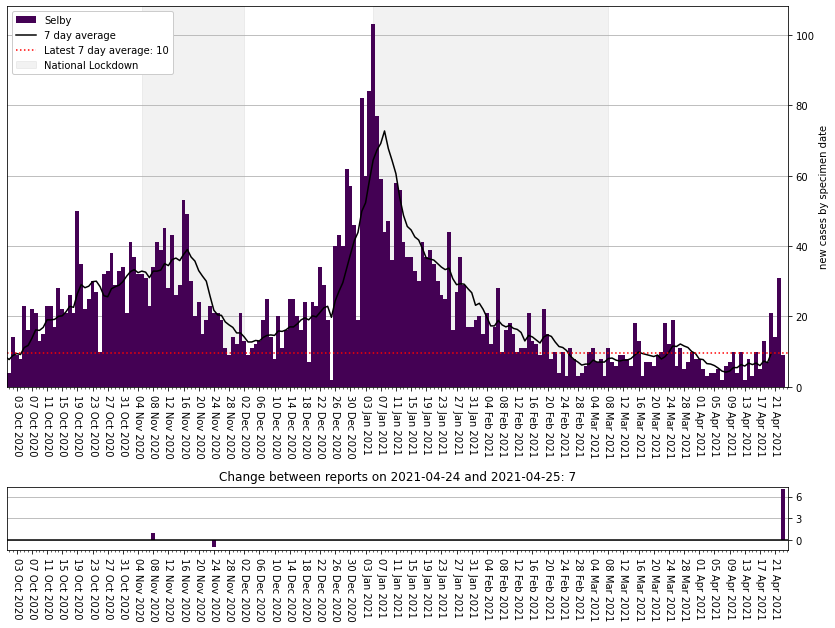

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,40.850343,324.0,2021-04-24
E08000034,Kirklees,65.258864,287.0,2021-04-24
E08000025,Birmingham,23.996861,274.0,2021-04-24
E08000032,Bradford,48.538653,262.0,2021-04-24
E08000019,Sheffield,40.864969,239.0,2021-04-24
E08000003,Manchester,39.612342,219.0,2021-04-24
E08000017,Doncaster,61.560165,192.0,2021-04-24
S12000049,Glasgow City,29.220369,185.0,2021-04-23
E08000036,Wakefield,52.826202,184.0,2021-04-24


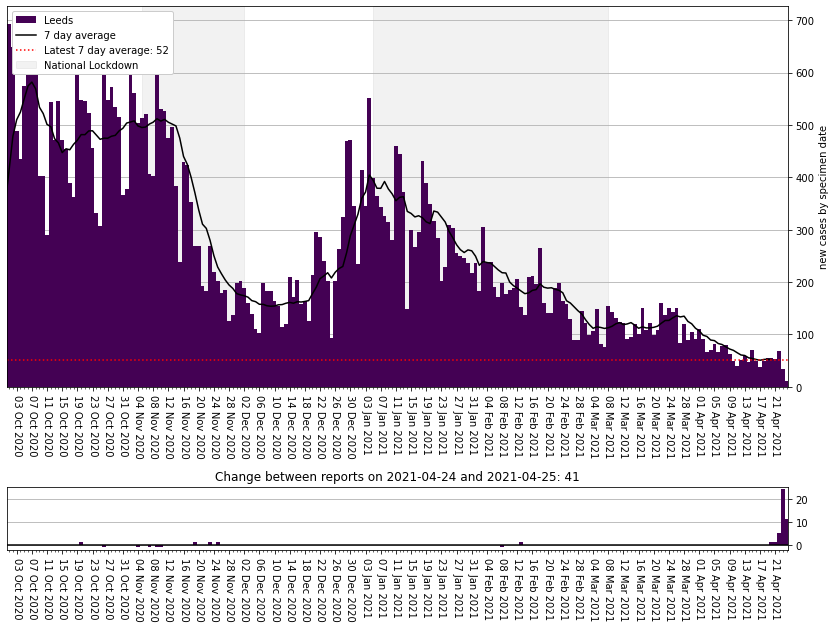

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.7
phe_max = 0.13

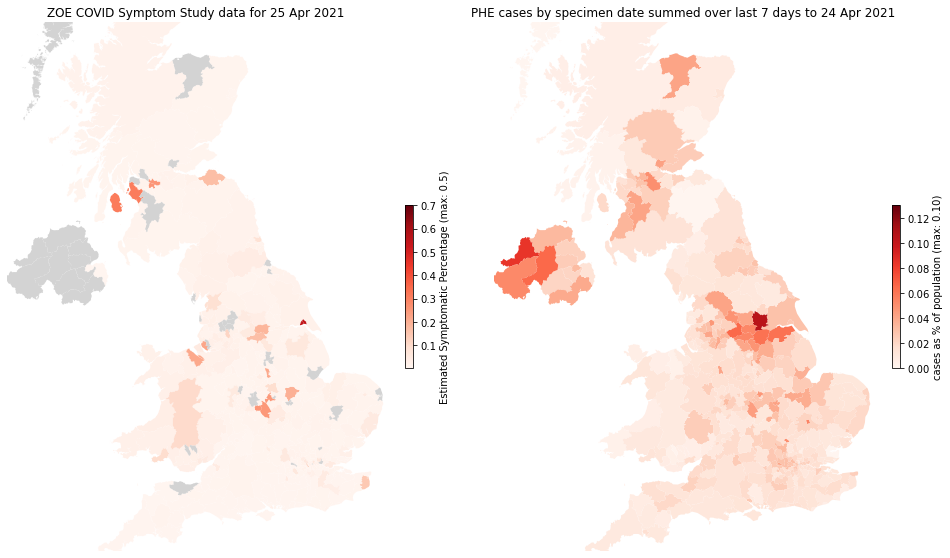

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...